# Technical extension - Impact of wealth on eating habits in Greater London

In [1]:
import os
import math
import numpy as np
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import spearmanr

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

## 1) Data preparation

In this part, we will load and prepare the datasets. First we load 2015 MSOA tesco 1.0 dataset and official London MSOA 2015 dataset. 

We add to tesco 1.0 dataset a wealth category calculated using KMeans clustering on total median annual household income. To see if there are social class differences in eating habits, we will create new features showing nutrients weight distribution that Tesco 1.0 dataset does not propose. For our studies, we will use the latents, the averge weight of each nutrient in purchased product within each area, the distribution of product weight and of product type.

###  A) Load datasets

#### Let's get the 2015 MSOA Tesco 1.0 dataset and the official London MSOA 2015 dataset (you can find a full description in the README).

In [2]:
root = "data/"
tesco_msoa_path = os.path.join(root,"year_msoa_grocery.csv")
msoa_profile_path = os.path.join(root,"msoa-data.csv")

In [3]:
tesco_msoa_df = pd.read_csv(tesco_msoa_path)
msoa_profile_df = pd.read_csv(msoa_profile_path,encoding = "ISO-8859-1")

In [4]:
print("Shape of tesco_msoa_df:", tesco_msoa_df.shape)
tesco_msoa_df.head(3)

Shape of tesco_msoa_df: (983, 202)


,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,323.685705,1.001360,98.849228,...,103934,6687.0,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069
1,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,550.434424,6.030232,118.288417,...,9952,7379.0,3549.0,3830.0,2150.0,4151.0,1078.0,35.567286,2.16,3416.203704
2,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,564.404826,4.398728,118.385615,...,19576,10720.0,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794


In paper dataset, we have 201 nutrition related features and 983 msoa areas.

In [5]:
print('Shape of msoa_profile_df:', msoa_profile_df.shape)
msoa_profile_df.head(3)

Shape of msoa_profile_df: (984, 207)


,Middle Super Output Area,MSOA Name,Age Structure (2011 Census);All Ages;,Age Structure (2011 Census);0-15;,Age Structure (2011 Census);16-29;,Age Structure (2011 Census);30-44;,Age Structure (2011 Census);45-64;,Age Structure (2011 Census);65+;,Age Structure (2011 Census);Working-age;,Mid-year Estimate totals;All Ages;2002,...,Road Casualties;2010;Slight,Road Casualties;2010;2010 Total,Road Casualties;2011;Fatal,Road Casualties;2011;Serious,Road Casualties;2011;Slight,Road Casualties;2011;2011 Total,Road Casualties;2012;Fatal,Road Casualties;2012;Serious,Road Casualties;2012;Slight,Road Casualties;2012;2012 Total
0,E02000001,City of London 001,7375,620,1665,2045,2010,1035,5720,7280,...,334,374,0,46,359,405,2,51,361,414
1,E02000002,Barking and Dagenham 001,6775,1751,1277,1388,1258,1101,3923,6333,...,18,18,0,2,16,18,0,1,15,16
2,E02000003,Barking and Dagenham 002,10045,2247,1959,2300,2259,1280,6518,9236,...,34,37,1,4,40,45,0,3,47,50


In official ward dataset, we have 207 different features about official statistics of each ward. We observe there are 984 msoa areas.

#### Now we will load geographic data of MSOAs for geovisualization.

In [6]:
msoa_map_path = os.path.join(root,"London","ESRI","MSOA_2011_London_gen_MHW.shp")
msoa_map_df = gpd.read_file(msoa_map_path)
print("Shape of msoa_map_df:", msoa_map_df.shape)
msoa_map_df.head(3)

Shape of msoa_map_df: (983, 13)


,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,"MULTIPOLYGON (((531667.624 180534.992, 531647...."
1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,"POLYGON ((548881.563 190845.265, 548881.125 19..."
2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,"POLYGON ((549102.438 189324.625, 548954.500 18..."


This dataset presents the localization of 983 msoa areas.

Text(0.5, 1.0, 'Geographic map of Greater London with MSOA boundaries')

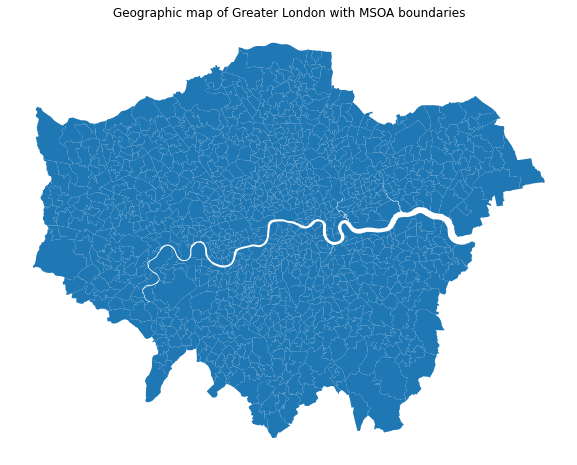

In [7]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.axis("off")
msoa_map_df.plot(ax=ax)
plt.title("Geographic map of Greater London with MSOA boundaries")

### B) Prepare datasets

To represent wealth of a MSOA area, we choose the median income as it has a better representativeness than the mean and is more robust to outliers.

In [8]:
# merge the median income to our main dataframe
official_useful_features = ["Household Income Estimates (2011/12);Total Median Annual Household Income (£);",
                            "Middle Super Output Area"]
main_df = tesco_msoa_df.merge(msoa_profile_df[official_useful_features],
                              left_on="area_id",right_on="Middle Super Output Area")

# Rename the column representing median income to shorter name
main_df = main_df.rename(columns={"Household Income Estimates (2011/12);Total Median Annual Household Income (£);":
               "median_income"}).drop(columns=["Middle Super Output Area"])
main_df.head(3)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,median_income
0,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,323.685705,1.001360,98.849228,...,6687.0,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069,46788
1,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,550.434424,6.030232,118.288417,...,7379.0,3549.0,3830.0,2150.0,4151.0,1078.0,35.567286,2.16,3416.203704,27059
2,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,564.404826,4.398728,118.385615,...,10720.0,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794,36835


#### As in the Tesco paper, let's filter the msoa that have representativeness norm lesser than a threshold = 0.1

In [9]:
ini_data_size = main_df.shape[0]
main_df = main_df[ main_df['representativeness_norm'] >= 0.1 ]

Let's quickly check how much data we discard with this threshold:

In [10]:
repr_data_size = main_df.shape[0]
prop = (ini_data_size-repr_data_size)/ini_data_size
print('With the chosen threshold we drop {:.2f}% of the msoa data'.format(prop*100))

With the chosen threshold we drop 9.87% of the msoa data


#### We add a f_{nutrient} field for each main nutrient: carb, fat, fibre, protein and alcohol

We will use these features to correlate wealth with distribution of nutrients per area.
We use the equation below:

$f_{nutrient_i}(a) = \frac{nutrient_i(a)}{\sum_j nutrient_j(a)}$

In [11]:
nutrients = ["fat","carb","fibre","protein","alcohol"]
all_nutrients = ["saturate","sugar"]
sum_df = main_df[nutrients].sum(1)
for n in nutrients+all_nutrients:
    main_df["f_"+n]=main_df[n]/sum_df
main_df.head(2)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,area_sq_km,people_per_sq_km,median_income,f_fat,f_carb,f_fibre,f_protein,f_alcohol,f_saturate,f_sugar
0,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,323.685705,1.001360,98.849228,...,2.90,2305.862069,46788,0.269292,0.501460,0.051479,0.166941,0.010828,0.106839,0.294863
1,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,550.434424,6.030232,118.288417,...,2.16,3416.203704,27059,0.252452,0.556163,0.045393,0.140914,0.005079,0.097060,0.305131


Let's validate the calculation by computing the nutrient weight entropy, it should be same as `h_nutrient_weigh` already in the dataset.

In [12]:
features = ["f_"+x for x in nutrients]

#entropy formulae from the Tesco paper (16)
entropy = -(main_df[features]*np.log2(main_df[features])).sum(1)

assert(np.sum(np.abs(entropy - main_df["h_nutrients_weight"]) > 1e-11) == 0)
#So our calculation is correct

### C) Cluster income levels using K-means

In this part, we labelize wealth category given the median income. To do so, we use K-means technique to minimize the intra-cluster variance and maximize the inter-cluster variance.

In [13]:
# Init a small dataframe with only median income and area_id (lighter to work on)
income_repr_msoa_df = main_df[['area_id','median_income']]

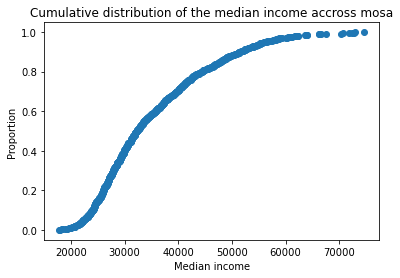

In [14]:
# Let's first plot the CDF of the incomes in MSOA
income_repr_msoa_df_sorted = income_repr_msoa_df.sort_values(by='median_income').reset_index(drop=True)
x_index_range=np.arange(0,income_repr_msoa_df.shape[0])/income_repr_msoa_df.shape[0]

plt.scatter(income_repr_msoa_df_sorted['median_income'],x_index_range)
plt.title("Cumulative distribution of the median income accross mosa")
plt.xlabel("Median income")
plt.ylabel("Proportion")
plt.show()

Now let's visualize different K-means clusterings we can get with K in [2,10]

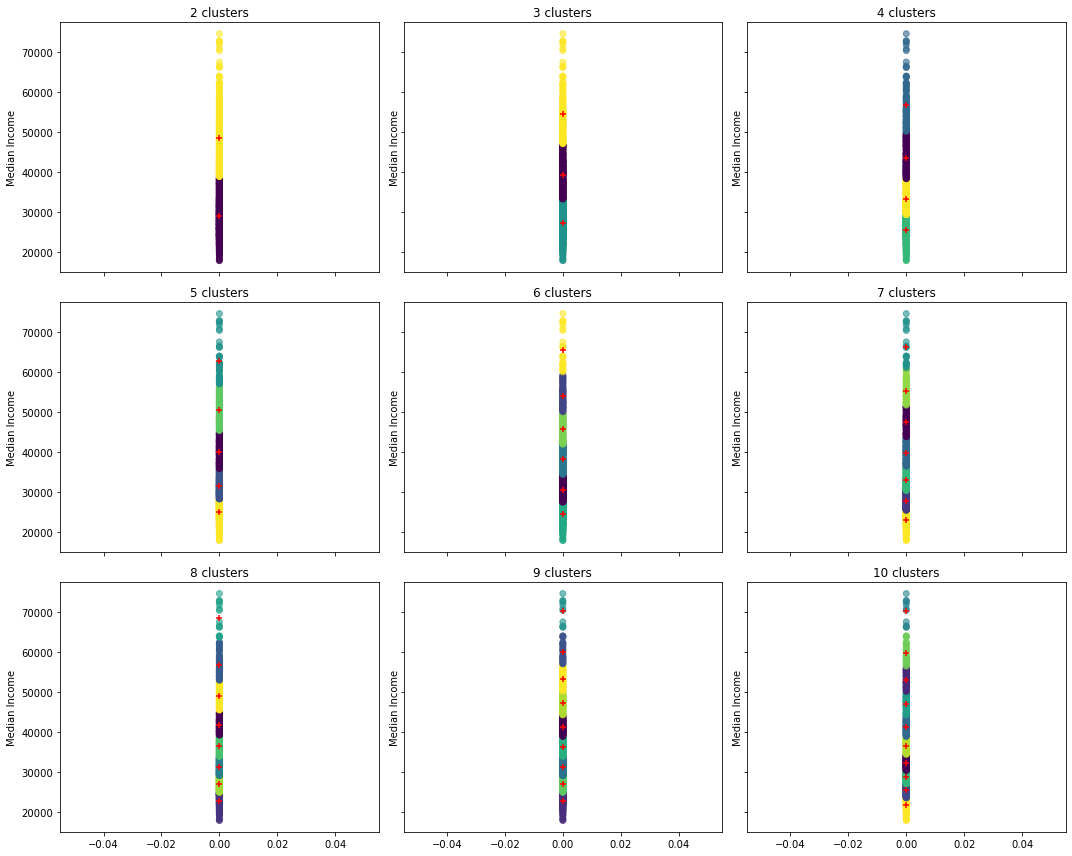

In [15]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 10

median_income = np.array(income_repr_msoa_df_sorted['median_income']).reshape(-1, 1)
x = np.zeros(median_income.shape[0])

# Compute number of row and columns for the graphs
COLUMNS = 3
ROWS = math.ceil((MAX_CLUSTERS-MIN_CLUSTERS)/COLUMNS)
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(15,12), sharey=True, sharex=True)

#store values of enertia to better choose the number of clusters
inertias=[]

# Plot the clusters
for n_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    current_column = (n_clusters-MIN_CLUSTERS)%COLUMNS
    current_row = (n_clusters-MIN_CLUSTERS)//COLUMNS
    
    # Get the axis where to add the plot
    ax = axs[current_row, current_column]
    
    # Cluster the data with the current number of clusters
    kmean = KMeans(n_clusters=n_clusters, random_state=42).fit(median_income)
    
    #store the inertia
    inertias.append(kmean.inertia_)
    
    # Plot the data by using the labels as color
    ax.scatter(x, median_income, c=kmean.labels_, alpha=0.6)
    ax.set_title("%s clusters"%n_clusters)
    ax.set_ylabel("Median Income")
    
    # Plot the centroids
    for c in kmean.cluster_centers_:
        ax.scatter(0, c, marker="+", color="red")
        
plt.tight_layout()

Also let's plot the inertia to better decide on the number of clusters.

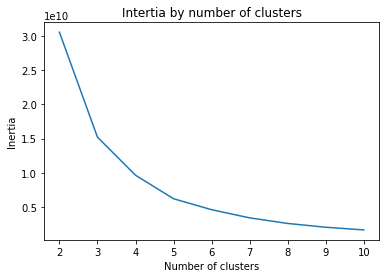

In [16]:
plt.plot(np.arange(MIN_CLUSTERS, MAX_CLUSTERS+1),inertias)
plt.title("Intertia by number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

5 clusters seems to separate the data fairly well and allow enough classes for our comparisons.

Let's give the following labels:  
Median income = {0=`very_low`, 1=`low`, 2=`medium`, 3=`high`, 4=`very_high`}

We can now include back in our main dataframe the cluster class of each MSOA:

In [17]:
CHOSEN_CLUSTER_NB = 5
wealth_class_labels = ['very_low', 'low', 'medium', 'high', 'very_high']

# Run k-means with the chosen number of clusters
data = np.array(income_repr_msoa_df['median_income']).reshape(-1, 1)
kmean = KMeans(n_clusters=CHOSEN_CLUSTER_NB).fit(data)

# Since the method does not return the labels sorted by increasing median_come we need to map them correctly
# Transforming the labels through a lookup table is a straightforward way to sort kmeans' labels
idx = np.argsort(kmean.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(CHOSEN_CLUSTER_NB)
labels = lut[kmean.labels_]

cluster_map = pd.DataFrame()
cluster_map['area_id'] = income_repr_msoa_df['area_id']
cluster_map['median_income'] = income_repr_msoa_df['median_income']
cluster_map['wealth_class'] = labels

print('Let\'s have a look at our median income cluster centers: \n', kmean.cluster_centers_)
cluster_map.head(3)

Let's have a look at our median income cluster centers: 
 [[40209.26923077]
 [24954.27972028]
 [62749.02439024]
 [50474.12096774]
 [31693.13438735]]


,area_id,median_income,wealth_class
0,E02000001,46788,3
1,E02000002,27059,0
2,E02000003,36835,2


In [18]:
main_df = main_df.merge(cluster_map[["area_id", "wealth_class"]],
                              left_on="area_id",right_on="area_id")
main_df.head(3)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,people_per_sq_km,median_income,f_fat,f_carb,f_fibre,f_protein,f_alcohol,f_saturate,f_sugar,wealth_class
0,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,323.685705,1.001360,98.849228,...,2305.862069,46788,0.269292,0.501460,0.051479,0.166941,0.010828,0.106839,0.294863,3
1,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,550.434424,6.030232,118.288417,...,3416.203704,27059,0.252452,0.556163,0.045393,0.140914,0.005079,0.097060,0.305131,0
2,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,564.404826,4.398728,118.385615,...,5009.345794,36835,0.257446,0.562147,0.042665,0.132752,0.004991,0.103066,0.339551,2


Now, we visualize some statistics about our labels with a boxplot and a countplot.

[Text(0, 0, 'very_low'),
 Text(1, 0, 'low'),
 Text(2, 0, 'medium'),
 Text(3, 0, 'high'),
 Text(4, 0, 'very_high')]

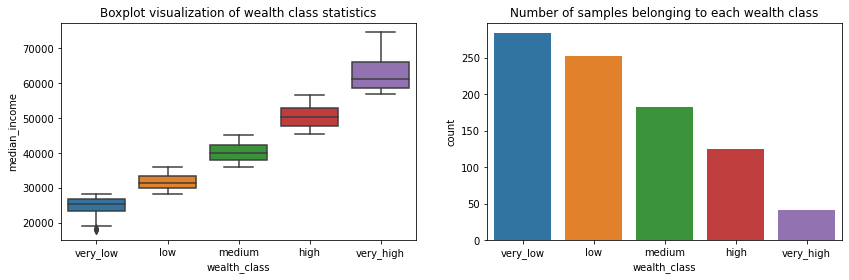

In [19]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(y=main_df["median_income"],x=main_df["wealth_class"],ax=ax[0])
sns.countplot(x=main_df["wealth_class"],ax=ax[1])

#set titles
ax[0].set_title("Boxplot visualization of wealth class statistics")
ax[0].set_xticklabels(wealth_class_labels)
ax[1].set_title("Number of samples belonging to each wealth class")
ax[1].set_xticklabels(wealth_class_labels)

So very low class areas have a median annual household income below 29'000 £, low class between 28'000 £ and 36'000 £, medium class between 36'000 £ and 45'000 £, high class between 45'000 £ and 57'000 $ and finally very_high have a median income greater than 57'000 £.
Finally we note as expected that number of areas with high and very high household income are much lower than the rest.

## 2) Visualization

In this part, we will get some intuition about the distribution of nutrient weight and purchased product types among MSOAs. First we will use T-SNE technique to spatial distribution of these features and see if there are similarities between features of same wealth class MSOAs. Then for nutrient distribution, we will geovisualize the distribution to see if there is any geographic pattern.

### A) T-SNE visualization

Let us define a tsne_vis function.

In [20]:
def tsne_vis(df, features, title):
    """"
    Utility visualization function to plot a T-sne 2D projection
    
    Args:
        - df: the full dataframe we apply t-sne
        - features: the features we're intrested in for the t-sne projection
        - title: the title of the plot
    """
    #Computes t_sne for features given as argument, we get 2D coordinates for each point
    tsne = TSNE(n_components=2,init='pca').fit_transform(df[features])
    plt.figure(figsize=(6, 5))
    labels = df.wealth_class.to_numpy()
    target_ids = np.unique(labels)
    
    #For 5 class, we have 5 colors
    colors = 'r', 'g', 'b', 'c', 'm'
    
    #For each label, we scatter the points with t-sne coordinate and corresponding color label
    for i, c, label in zip(target_ids, colors, wealth_class_labels):
        plt.scatter(tsne[labels == i, 0], tsne[labels == i, 1], c=c, label=label)
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.legend()
    plt.title(title)
    plt.show()

First, we set the vector of average nutrient weight as first feature for each area.

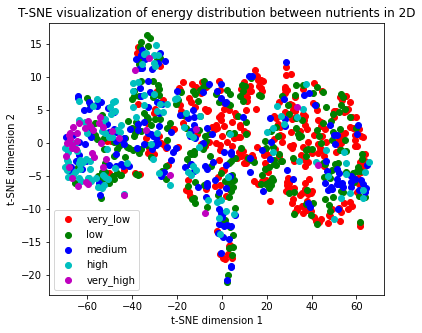

In [21]:
nutrients=["fat","fibre","protein",
          "carb","alcohol","sugar","saturate","salt"]
tsne_vis(main_df, nutrients, "T-SNE visualization of energy distribution between nutrients in 2D")

We don't observe clear difference in eating habits between MSOAs except between very_high and very_low for which there is not overlap.

Let's try with another feature, the distribution of dishes type bought by the customers and fraction of total product weight given by each product type.

In [22]:
feats = []
feats_weight = []
# We select the columns corresponding to the fractions of products types as well as their weight fractions
for col in main_df.columns:
    # Here we focus on products types so we do not include energy and nutrients
    if "f_" in col and "energy" not in col and col not in nutrients:
        if "weight" in col:
            feats_weight.append(col)
        else:
            feats.append(col)
print("We run the t-SNE on", len(feats), 
      "features which are all fractions of products types.")
print("We run the t-SNE on", len(feats_weight), 
      "features which are all weight fractions of products types.")

We run the t-SNE on 24 features which are all fractions of products types.
We run the t-SNE on 11 features which are all weight fractions of products types.


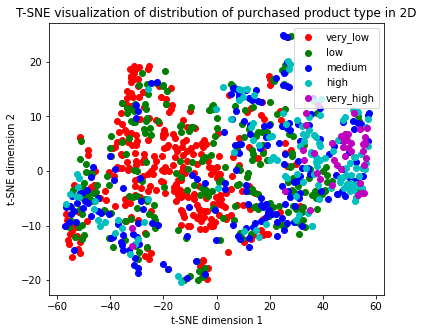

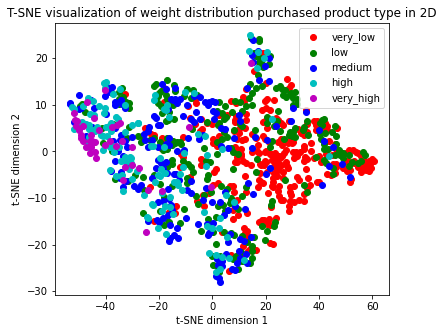

In [23]:
tsne_vis(main_df, feats,"T-SNE visualization of distribution of purchased product type in 2D")
tsne_vis(main_df, feats_weight,"T-SNE visualization of weight distribution purchased product type in 2D")

Again the clustering effect is not very visible for non-extreme classes
Very-low and very-high cluster a little better and are fairly separated, giving us an intuition that indeed there might be different eating habits between these two classes. We note that merging high and very_high would still not overalp with very_low cluster in both T-SNE.

### B) London choropleth map

First we will visualize the mean weight of each nutrient in products purchased at msoa level. Let's define a function to output a choropleth map. 

We will set in grey color the MSOA with low representativeness so that they can be better differentiated from the "valid" areas.

In [24]:
def london_vis(geo_map, data_df, ax, variable, geo_map_index="MSOA11CD", data_df_index="area_id"):
    """
    Utility visualization function to plot the Upper London map with per region levels
    
    Args:
        - geo_map : the London MSOA map dataframe
        - data_df : the dataframe with all features to display
        - ax : the axis of the plot to display on
        - variable : the name of the current feature we display on the map
        - geo_map_index : the name of the area index in the geo_map dataframe 
        - data_df_index : the name of the area index in the data_df dataframe 
    """
    # merge the two given df using their index label arguments
    merged_df = geo_map.merge(data_df,left_on=geo_map_index,right_on=data_df_index, how="left")
    
    #set the background background to grey for the missing values
    merged_df.plot(ax=ax,color="lightgrey")
    
    merged_df.plot(ax=ax,column=variable, cmap='Blues',linewidth=0.2,edgecolor='0.8',legend=True)
    ax.annotate('Source: London Datastore, 2014 and Tesco 1.0 dataset',xy=(0.1, .0),  
                xycoords='figure fraction', horizontalalignment='left', 
                verticalalignment='top', fontsize=12, color='#555555')
    ax.set_title("Comparison of {:s} between each MSOA of Greater London".format(variable))

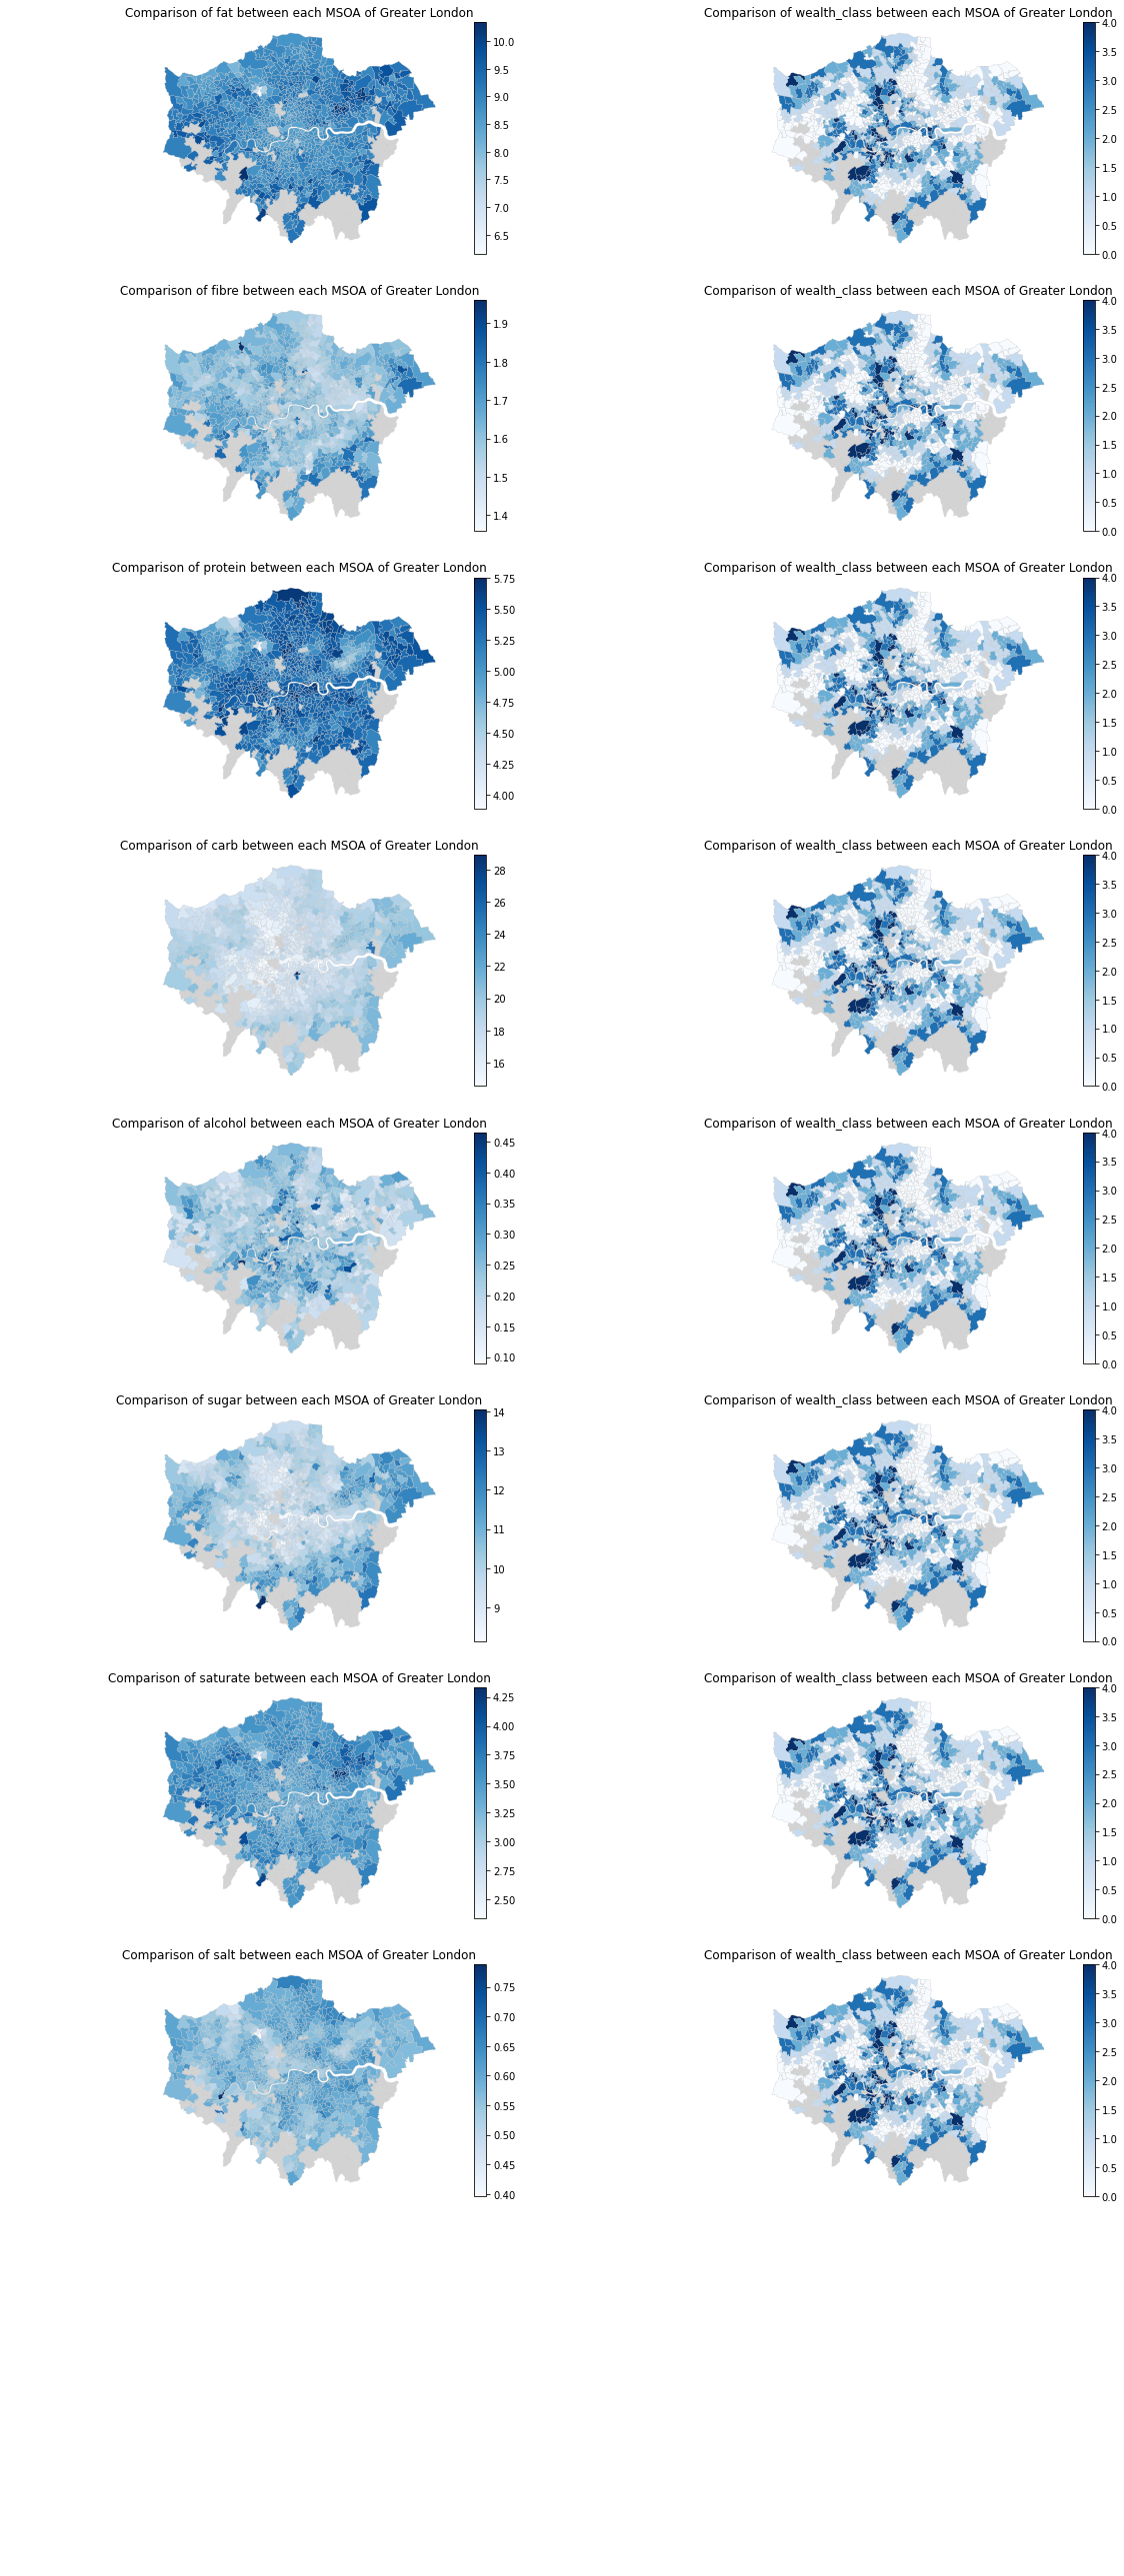

In [25]:
fig, ax = plt.subplots(len(nutrients),2, figsize=(20,5*len(nutrients)))

figures = []
for f in nutrients:
    figures += [f,"wealth_class"]

for ax_,feat in zip(ax.reshape(-1), figures):
    df_feats = ["area_id"]+[feat]
    london_vis(msoa_map_df, main_df[df_feats],ax_,feat)
    ax_.axis("off")

For each line, we compare the wealth class distribution with the nutrient distribution with geographic map.

It is hard to observe clear geographic patterns in these plots. We can still dicern for carb, in the center, the white areas meaning a very low weigh of carb correlated with high wealth class. As T-SNE, this visualization is not indicative of a correlation between wealth indicator and distribution of nutrients.
Since this visualization makes observation hard, we will not use it for product type fraction features.

### C) Other visualization

Now, we are interested in digging further for purchased product type distribution. Let us plot a heatmap which will show for each wealth class the mean weight fraction of each product type purchased. We also add the normalized entropy of weight of food product categories as wealth indicator, high entropy would mean "eating well".  
For all product not having a weight fraction feature, we show the product fraction feature instead. 

First, we define a heatmap visualization function.

In [26]:
def heatmap_vis(main_df, features, classes, ylabel, xlabel, title):
    """
    The function plots a heatmap given wealth classes and features. For each class and each feature,
    it computes the average feature value among all elements within the class.
    
    Args:
        - main_df : the pandas dataframe having a wealth_class and the features
        - features : the list of features to evaluate
        - classes : the wealth class labels
        - ylabel : the y label for the heatmap
        - xlabel : the x label for the heatmap
        - title  : the title of te heatmap
    """
    #Init grid
    grid=np.zeros((len(classes),len(features)))

    #populate the grid
    for wcl_i,wcl in enumerate(classes):
        by_wcl=main_df[main_df.wealth_class==wcl_i]
        for n_i,category in enumerate(features):
            grid[wcl_i,n_i]=by_wcl[category].mean()

    #Normalize between 0 and 1 to share same scale for each feature
    grid=(grid-grid.min(axis=0))/(grid.max(axis=0)-grid.min(axis=0))

    plt.subplots(figsize=(21, 3))
    ax=sns.heatmap(grid,xticklabels=features, yticklabels=classes)
    ax.set(ylabel=ylabel, xlabel=xlabel,title=title)
    plt.show()

Below, we extract categories name and use our function to plot the heatmap. We add normalized nutrient energy as wealth indicator.

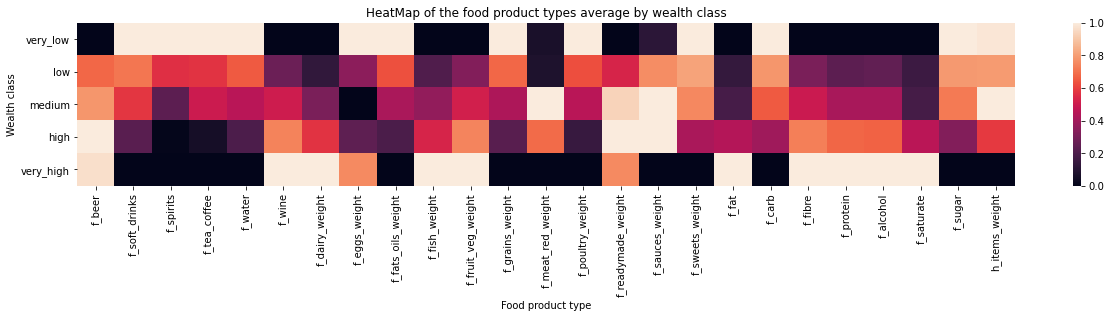

In [27]:
categories_names=[]
for c in main_df.columns:
    if c.startswith("f_") and "energy" not in c and c+"_weight" not in main_df.columns and c not in nutrients:
        categories_names.append(c)
categories_names.append("h_items_weight")
heatmap_vis(main_df, categories_names, wealth_class_labels, 
            "Wealth class", "Food product type", "HeatMap of the food product types average by wealth class")

We observe some nutrients are correlated with wealth class:

For example the comsumption of wine, fish, dairy products, fruit&vegetables and beer are correlated with high social class value.

Whereas the comsumption of soft drinks, spirits, grains, poultry and sweets are correlated with low social class value. 

Additionally we observe the entropy does not show wealth correlation.

Let's make the same visualization with distribution of nutrient weight, we also add the nutrient weight entropy as wealth indicator.

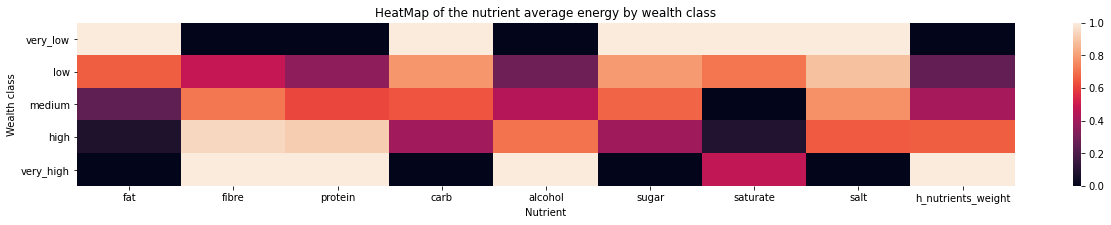

In [28]:
nutrients+=["h_nutrients_weight"]
heatmap_vis(main_df, nutrients, wealth_class_labels, 
            "Wealth class", "Nutrient", "HeatMap of the nutrient average energy by wealth class")

This heatmap gives us more information than the choropleth and t-sne visualization.
Some nutrients are correlated with wealth class:

We observe fibre, protein, alcohol and the nutrients entropy are correlated with high wealth class wheras salt, fat, carb and sugar are correlated with low class value. Finally for saturate fat, we don't observe clear correlation.

These heatmaps show evidence of class difference in eating habits. Since we have distribution data like weight distribution of nutrient and of product type, we will try another type of visualization: the pie chart. For this we will use fractions data (f_{nutrient}) instead of only the weight.

(0.0, 1.0, 0.0, 1.0)

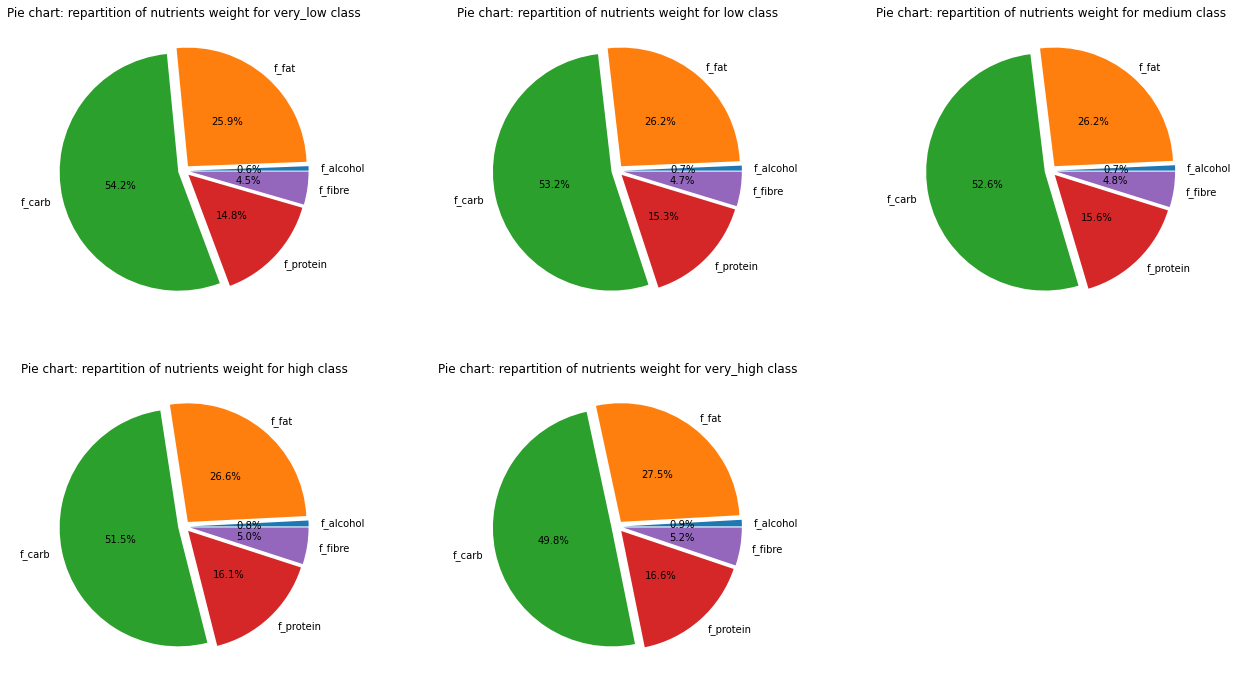

In [29]:
fig, ax = plt.subplots(2,3,figsize=(22,12))
ax = ax.reshape(-1)

f_nuts=["f_alcohol","f_fat","f_carb","f_protein","f_fibre"]
#Compute the mean fraction for each class
agg_chart = main_df[f_nuts+["wealth_class"]].groupby("wealth_class").mean()

#Add a pie chart for each label class
for i in range(agg_chart.shape[0]):
    values = agg_chart.loc[i].values
    labels = agg_chart.loc[i].index
    ax[i].pie(x=values, autopct="%.1f%%", labels=labels, normalize=True,
               explode=[0.05]*len(values), pctdistance=0.5)
    ax[i].set_title("Pie chart: repartition of nutrients weight for {:s} class".format(wealth_class_labels[i]))
ax[-1].axis("off")

In these picharts we see the differences in proportions are quite small. If we observe carefully, we see the percentage of protein increases by 0.3-0.6% for each class increase. The same phenomena can be observed for fat, alcohol and fiber. Thus the fraction of carb decreases with higher class level. 

So indeed, there is an actual evidence of social class difference in eating habits. Yet, this does not show clear correlation between wealth and healthy products. Let us study this further in the next steps.

### D) Hypotheses

#### We make the following hypotheses:

a) We observed consumption of "healthy product" like fish and dairy products and fruit&vegetables are correlated with high social class value while "non healthy product" like soft drinks, spirits, sweets are correlated with low class value. So we make the hypothesis that areas where customers buy bigger proportion of healthy product are likely wealthy and areas where customers buy bigger proportion of unhealthy product are likely non wealthy.

b) In heatmap, we observed a correlation between "healthy nutrient" like fibre and protein with high class value. We observe a same correlation for the healthy marker "entropy of nutrients". We also observe a correlation between sugar, salt and carb with low social class. We make the hypothesis that areas where the average weight of healthy nutrients (fibre, protein, etc..) is big and where the average weight unhealty nutrient (sugar, salt, etc..) is low are likely wealthy and vice-versa.

You will note we don't explicity hypothetize about the impact of wealth on eating habits. Below we explain why verifying these hypotheses will show that people in wealthy areas have higher probability to get healthy eating habits than people not in them.

Let H be the event eating healthy and W living wealthy. Our hypotheses are globally saying:

$P(W|H) > P(\overline{W}|H)$

Since the prior probability to be a wealthy area is much lower (as seen in part 1), validating this hypothesis would also validate:

$P(H|W) > P(H|\overline{W})$

which means we are more likely to eat healthier when having higher incomes.

## 3) Hypotheses verification

To verify both hypotheses, we proced in three steps:

 a) We compare distribution of each feature within each class using hist plot
 
 b) We use spearman's rank correlation to show significant correlation between a feature and the median_income. We used the wealth_class for better vizualization, but now, since the wealth_class only depends on the median income we can use the continuous version to obtain a more precise estimate for the correlation.

 c) We use logistic regression to estimate the probability that an area is wealthy given distribution of purchased product types features and nutrients. By using statsmodel, we will know which features lowers or not the probability. To simplify the understanding, we will labelize high and very_high level areas as 1 and the others as 0.

#### We define utility functions for each part:

In [30]:
def a_hist_plots(main_df, categories_names, wealth_class_labels,plot_type='hist'):
    """
    The function plots a grid of histograms, each time ploting an histogram of the columns of the given
    dataframe whose name is in categories_names, for each differente wealth_class.
    
    Args:
        - main_df : the pandas dataframe having a wealth_class and the categories_names
        - categories_names : the list of categories to be ploted
        - wealth_class_labels : the wealth class labels
        - plot_type: the type of plot we want, either the histogram or its corresponding function estimates
    """
    #set the width of the grid to a constant
    width=4
    #set the vetiacl number of plot accordingly
    height=math.ceil(len(categories_names)/width)

    #set up the figure size
    f = plt.figure(figsize=(20,6*height))
    
    # the colors
    color_set=["#8ebad9","#ffbe86","#95cf95","#ea9293","#c9b2dd"]

    #iterate over the categories to consider
    for idx_c,c in enumerate(categories_names):
        #add a plot at the correct place
        ax= f.add_subplot(height,width,idx_c+1)
        #iterate over the wealth class
        for wc in range(len(main_df.wealth_class.unique())):
            #plot the histogram
            if plot_type=="hist":
                ax.hist(main_df[main_df.wealth_class==wc][c], alpha=0.5, label=wealth_class_labels[wc])
            elif plot_type=="kde":
                sns.kdeplot(main_df[main_df.wealth_class==wc][c],
                            label=wealth_class_labels[wc],ax=ax, color=color_set[wc])
            else:
                raise NotImplementedError
        
        plt.title("Histogram of the fraction of " + str(c).replace("f_","") + " by wealth class", size=9)
        plt.xlabel("fraction of " + str(c).replace("f_","") )
        plt.ylabel("number of msoa")
        plt.legend()
    plt.show()

In [31]:
def b_spearman_rank(main_df, categories_names):
    """
    The function return a dataframe of the spearman rank correlation between the median_income and the food categories.
    
    Args:
        - main_df : the pandas dataframe having a column median_income and the categories_names
        - categories_names : the list of categories to checked for correlation with the median_income
    """   
    #initialise the dataframe
    spearman_df=pd.DataFrame(columns=["feature_name","coef","p_value","log10_p_value"])

    #compute all correlation
    for category in categories_names:
        # compute spearman's rank correlation
        coef, p = spearmanr(main_df["median_income"],main_df[category])
        #append the coefficient and p_values
        spearman_df=spearman_df.append(
            {"feature_name":category,"coef":coef,"p_value": p,"log10_p_value":int(np.ceil(np.log10(p)))}
            ,ignore_index=True)
    
    return spearman_df

In [32]:
def display_spearmanRank_textual(spearman_df):
    """
    The function prints a textual visualization of the given dataframe interpreted
    as the representation of spearman rank coefficients and the p-value.
    It only displays those that are statisticaly significant
    
    Args:
        - spearman_df : the pandas dataframe with the spearmanRank attributes
    """    
    SIGNIFICANT_THRESHOLD=0.05

    print("Following categories have a statisticaly significant correlation with the median income\n\n")
    print("First those that are positively correlated with median income\n")
    pos_corr=spearman_df[(spearman_df.p_value<SIGNIFICANT_THRESHOLD) 
                         & (spearman_df.coef>0)].sort_values(by='coef',ascending=False)
    for row in pos_corr.iterrows():
        print("- %18s have coefficient %+.2f with p value of order 10^%d"
              %(row[1].feature_name,row[1].coef,row[1].log10_p_value))

    print("\n\nNow those that are negatively correlated with median income\n")
    neg_corr=spearman_df[(spearman_df.p_value<SIGNIFICANT_THRESHOLD) 
                         & (spearman_df.coef<0)].sort_values(by='coef')
    for row in neg_corr.iterrows():
        print("- %18s have coefficient %+.2f with p value of order 10^%d"
              %(row[1].feature_name,row[1].coef,row[1].log10_p_value))

In [33]:
def display_spearmanRank_histogram(spearman_df, title):
    """
    The function prints a histogram visualization of the given dataframe interpreted
    as the representation of spearman rank coefficients and the p-value.
    It only displays those that are statisticaly significant
    
    Args:
        - spearman_df : the pandas dataframe with the spearmanRank attributes
    """    
    SIGNIFICANT_THRESHOLD=0.05
    
    coef=spearman_df.coef.copy()
    labels=spearman_df.feature_name
    p_values=spearman_df.p_value

    colors=['#2478A8' if coefficient>0 else '#E29638' for coefficient in coef]
    
    coef[p_values>=SIGNIFICANT_THRESHOLD]=np.nan

    plt.bar(labels,height=coef,color=colors)
    plt.grid(axis='y',fillstyle='none')
    plt.title(title)
    plt.ylabel("R")
    plt.xticks(rotation=90)
    plt.show()

In [34]:
def c_logistic_regression(main_df, categories_names):
    """
    The function displays the olsmodel textual representation, trying to fit the wealth classes
    from the features whose name are in categories_names.
    
    Args:
        - main_df : the pandas dataframe having a column median_income and the categories_names
        - categories_names : the list of categories
    """    
    #generate the fomula
    formula='wealth_class ~ '
    for i, nn in enumerate(categories_names):
        if i==0:
            formula+=nn
        else:
            formula+=(" + "+nn)

    #standardize the main_df before fitting the linear model
    #standardized_main_df=(main_df-main_df.mean())/main_df.std()
    standardized_main_df=main_df.copy()
    
    #We give binary label to wealth class; high and very high are set to 1, others to 0
    standardized_main_df.loc[main_df["wealth_class"] <= 2,"wealth_class"]=0
    standardized_main_df.loc[main_df["wealth_class"] > 2,"wealth_class"]=1
    
    """
    standardized_main_df["median_income"]=(standardized_main_df["median_income"]
                    -standardized_main_df["median_income"].min())/(standardized_main_df["median_income"].max()
                                                                -standardized_main_df["median_income"].min())
    """

    #fit the linear model and display it
    ols_model = smf.logit(formula, data=standardized_main_df).fit()
    print(ols_model.summary())

    # feature names
    variables = ols_model.params.index

    # quantifying uncertainty!

    # coefficients
    coefficients = ols_model.params.values

    # p-values
    p_values = ols_model.pvalues

    # standard errors
    standard_errors = ols_model.bse.values
    
    #sort them all by coefficients
    l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))
    
    plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

    plt.vlines(0,0, len(l1), linestyle = '--')

    plt.yticks(range(len(l2)),l2)

#### Categories fraction study

#### a) histogram plot

Within each class, we compare distribution of some category fraction.

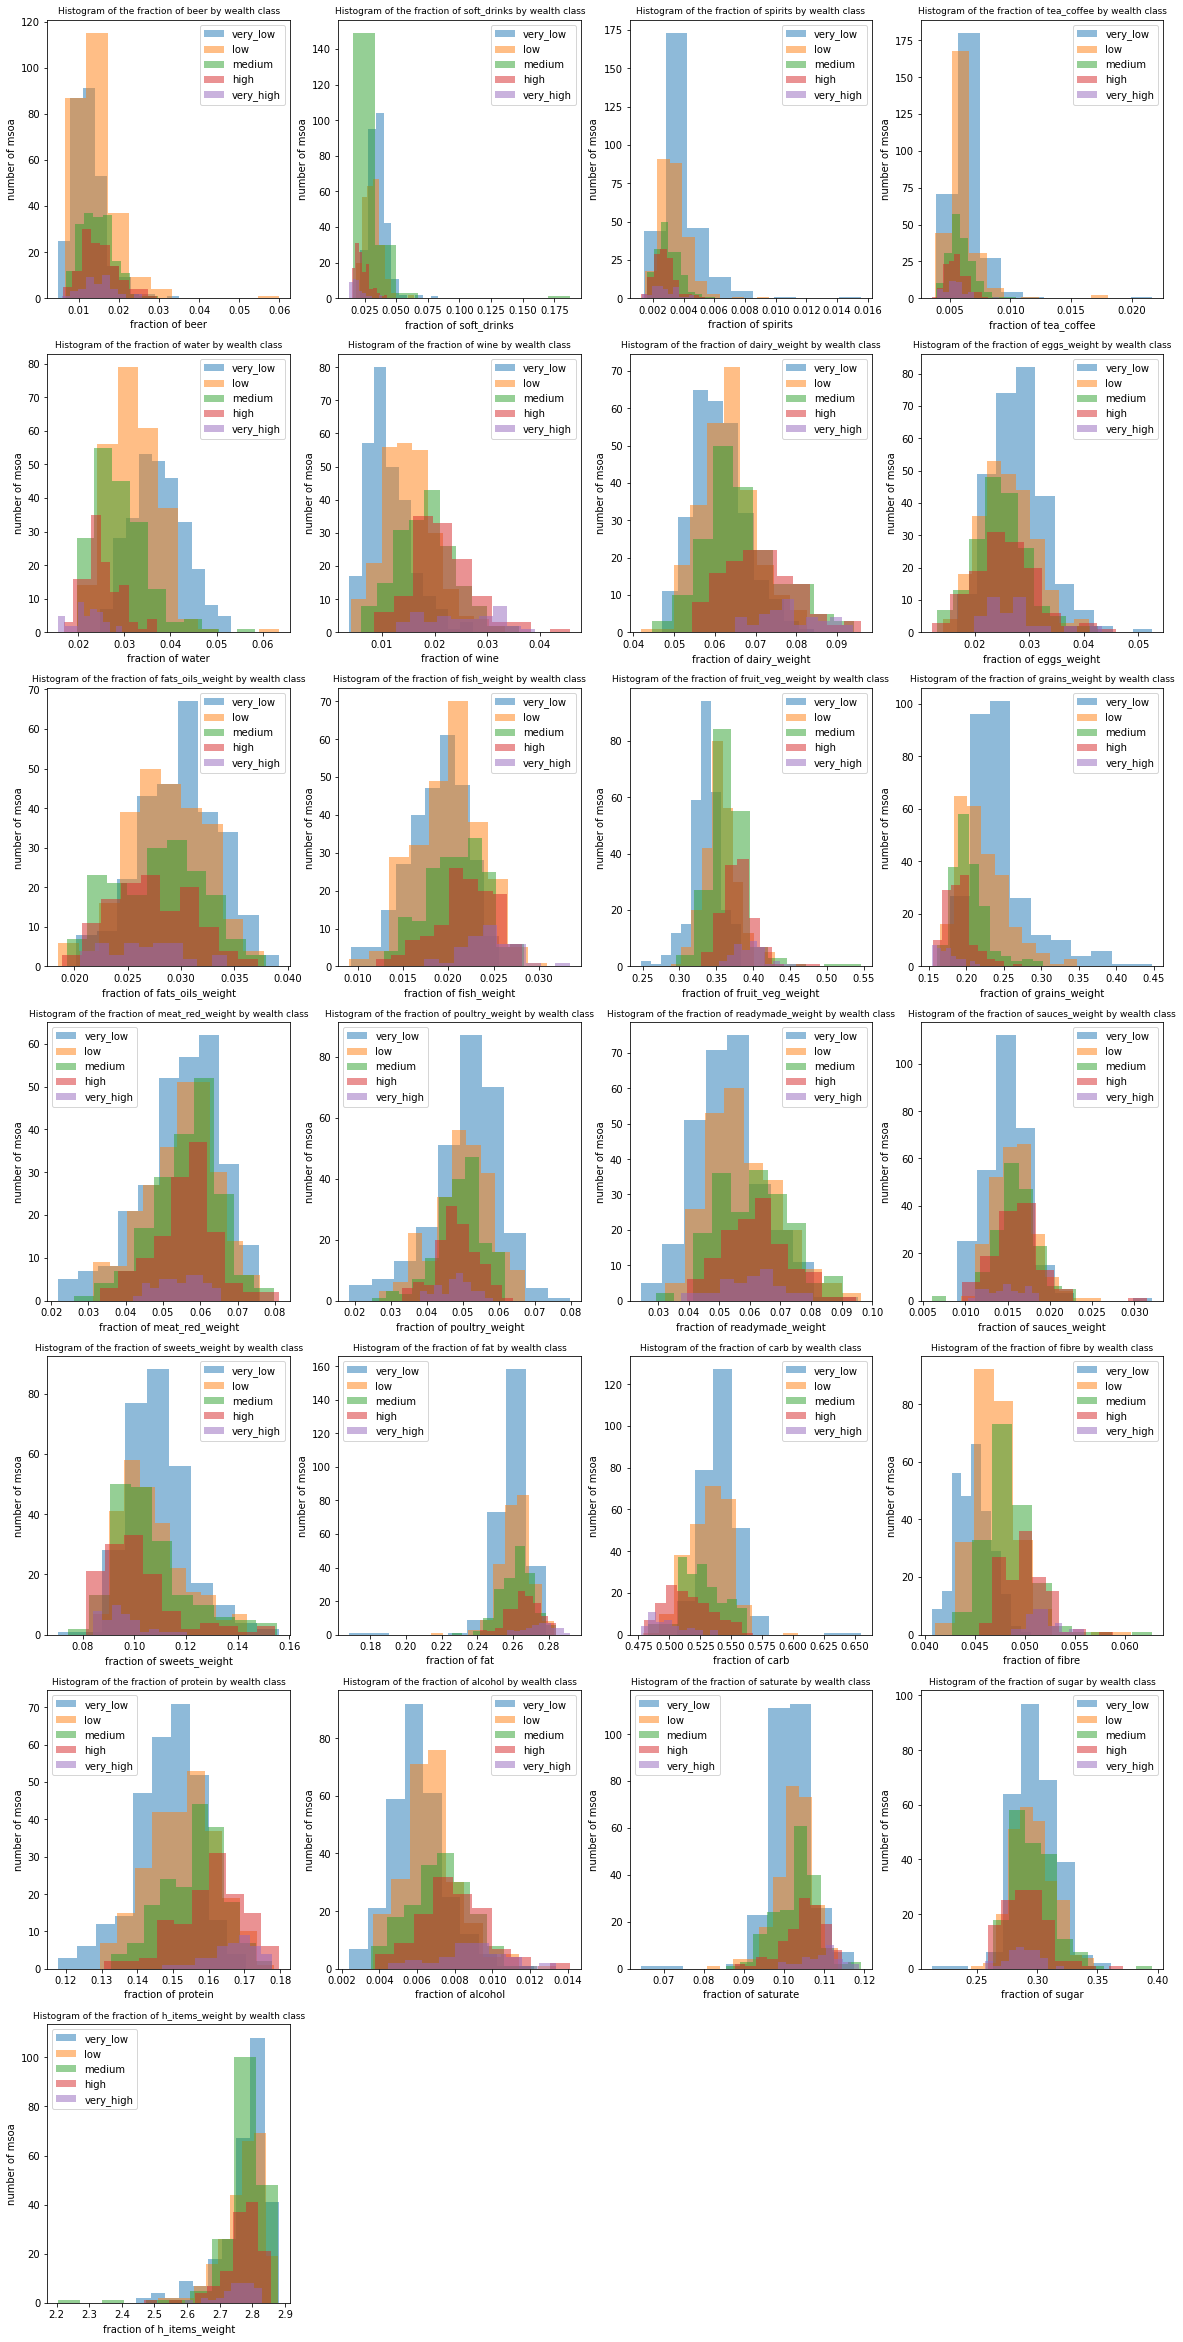

In [35]:
a_hist_plots(main_df, categories_names, wealth_class_labels,plot_type="hist")

Let's smooth the curves to see the distribution better

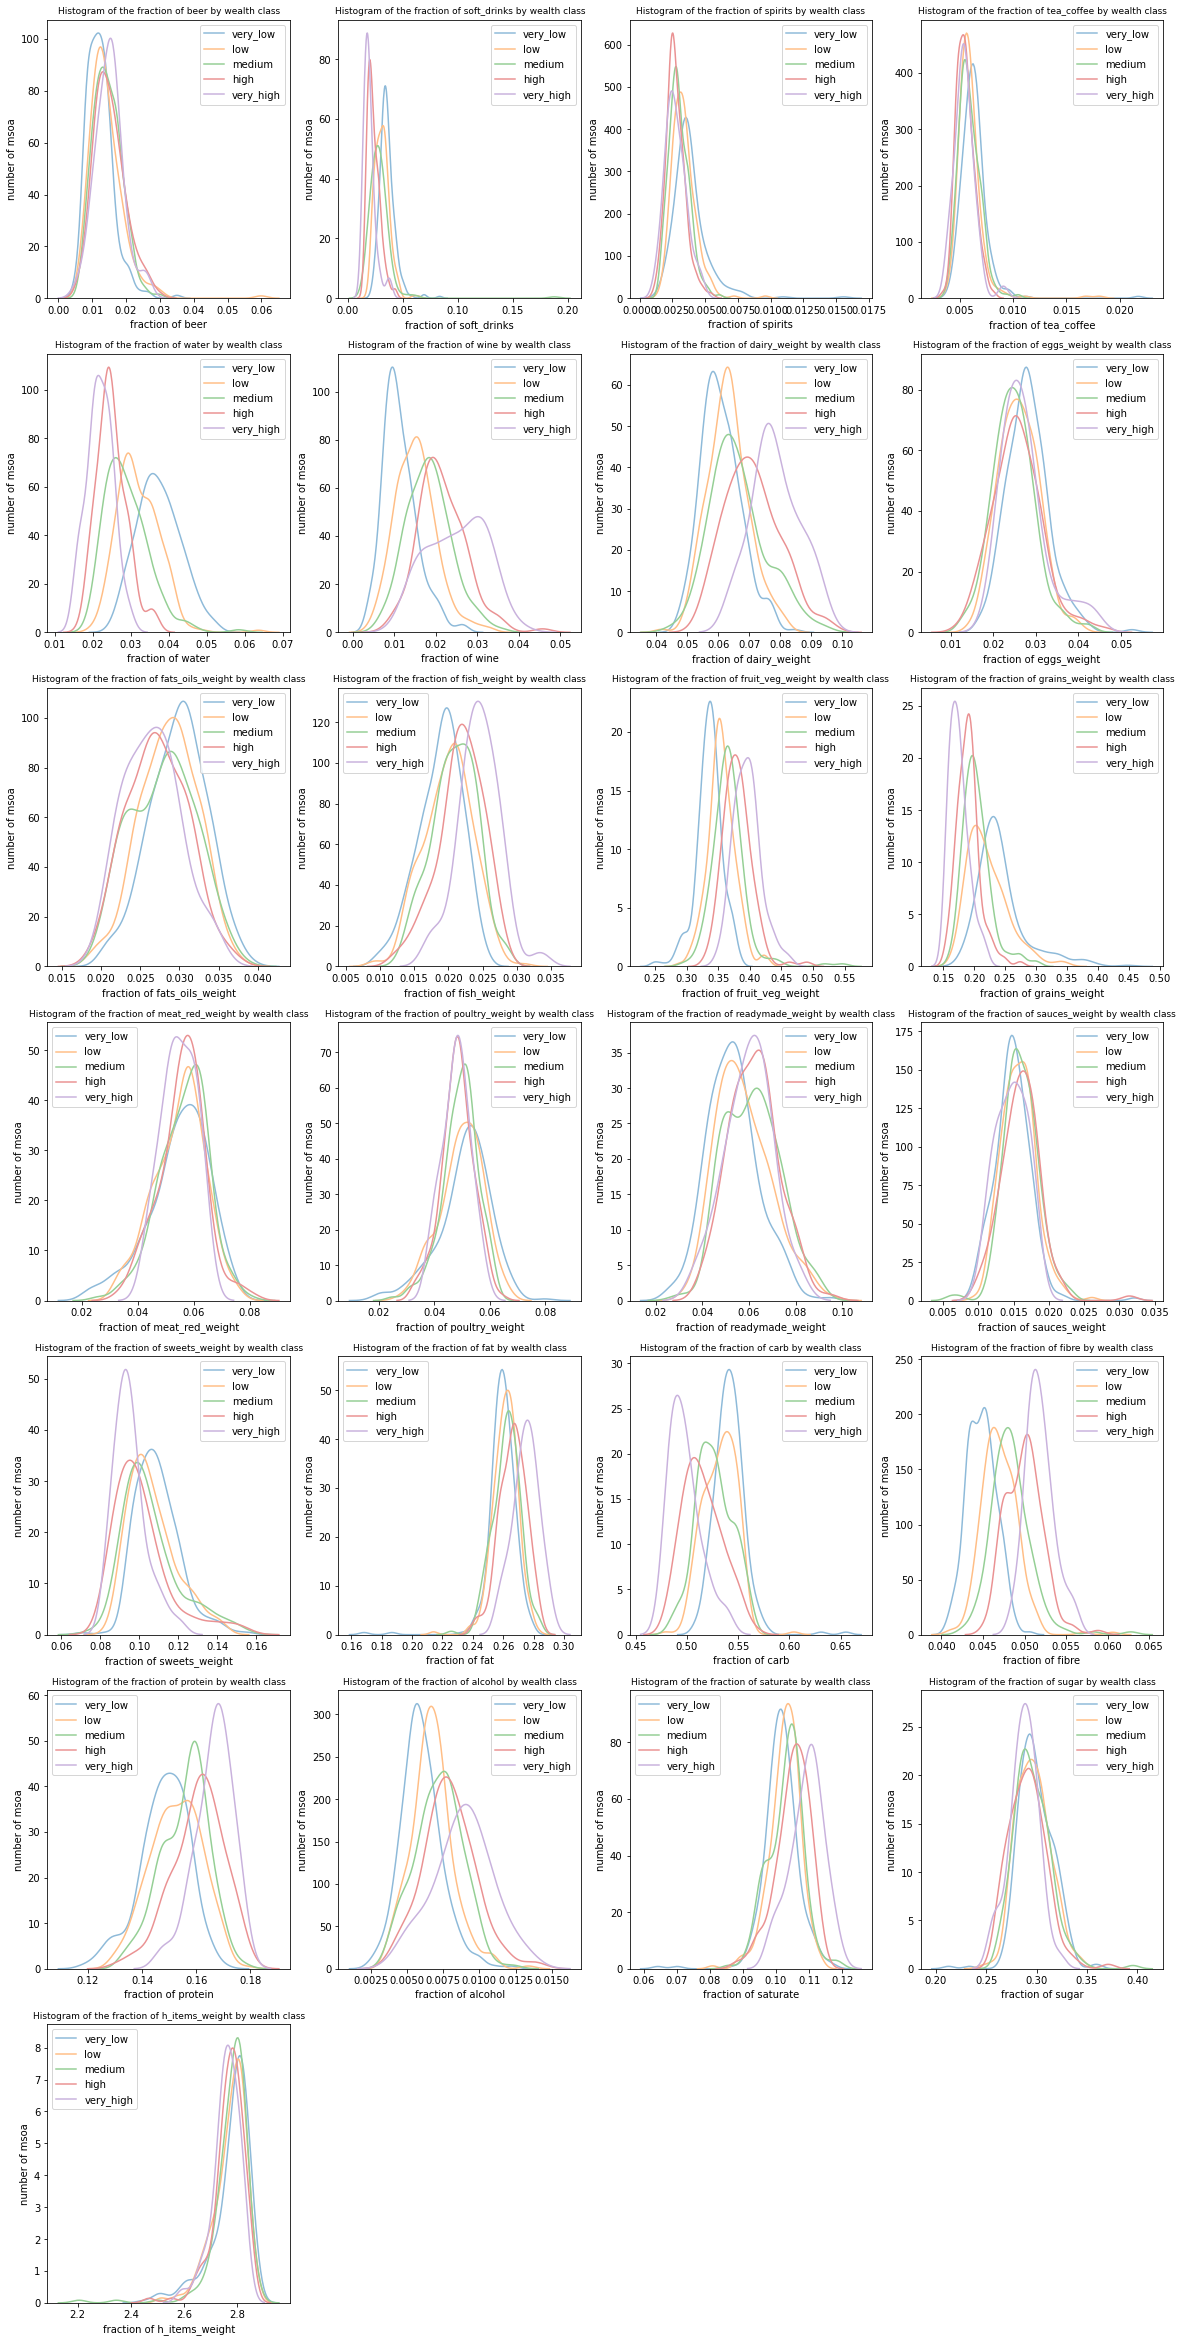

In [36]:
a_hist_plots(main_df, categories_names, wealth_class_labels,plot_type="kde")

We make same observations as in visualization part; wine, dairy weight, fish_weight, fruit&vegetable weight seem to be positvely correlated with wealth class while water, grains_weight, sweets_weight, soft drinks and spirits seem to be negatively correlated.

#### b) Spearman correlation

Let us verify this by computing spearman correlations with those features and the median income.

In [37]:
display_spearmanRank_textual(b_spearman_rank(main_df, categories_names))

Following categories have a statisticaly significant correlation with the median income


First those that are positively correlated with median income

-            f_fibre have coefficient +0.73 with p value of order 10^-148
- f_fruit_veg_weight have coefficient +0.66 with p value of order 10^-110
-             f_wine have coefficient +0.66 with p value of order 10^-109
-          f_protein have coefficient +0.48 with p value of order 10^-50
-          f_alcohol have coefficient +0.47 with p value of order 10^-48
-     f_dairy_weight have coefficient +0.44 with p value of order 10^-42
-      f_fish_weight have coefficient +0.35 with p value of order 10^-25
- f_readymade_weight have coefficient +0.32 with p value of order 10^-22
-              f_fat have coefficient +0.32 with p value of order 10^-21
-         f_saturate have coefficient +0.31 with p value of order 10^-20
-             f_beer have coefficient +0.29 with p value of order 10^-18
-    f_sauces_weight have coefficient +0.

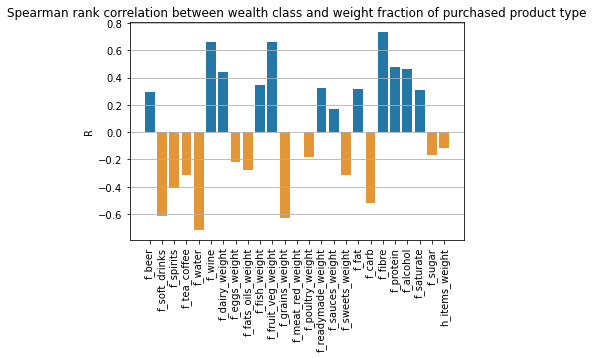

In [38]:
display_spearmanRank_histogram(b_spearman_rank(main_df, categories_names),
          "Spearman rank correlation between wealth class and weight fraction of purchased product type")

All above correlations are statistically significant. We note strong postitive correlations between wealth class and both fruit&vegetables, dairy, fish which are markers of healthy eating habits. We note strong negative correlation between wealth class and sweets, soft drinks which are marker of unhealty eating habits.

We also note a strong positive correlation for wine and negative correlation for water.
We can only make hypothesis about this strong correlation, the most likely one that we could think of is that the amount of water bought does not vary significanlty but because the wealthier population buys more products then the fraction of them represented by water is reduced. About wine, is it not surprising that, as it is wealthy product, its consumption is correlated with the median income.

#### c) logistic regression

Finally we use logistic regression to estimate the median income with food categories and entropy. 

We want to know if we can predict the wealth class with the fractions of purchased healthy and unhealthy product type.
For this we use logistic regression. We want to simplify the things, we will give two features; healthy and unhealthy. For healthy product, we select fruit&vegetable, dairy and fish, we sum their fractions and create a feature `healthy`. For unhealthy product, we select fat oils weight and sweets weight, we sum them and create a feature `unhealthy`.

In [39]:
lin_df = main_df.copy()
lin_df["healthy"]=lin_df["f_dairy_weight"]+lin_df["f_fish_weight"]+lin_df["f_fruit_veg_weight"]
lin_df["unhealthy"]=lin_df["f_fats_oils_weight"]+lin_df["f_sweets_weight"]
sa = [f for f in categories_names if "weight" in f and "f_" in f]

Optimization terminated successfully.
         Current function value: 0.341762
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:           wealth_class   No. Observations:                  886
Model:                          Logit   Df Residuals:                      882
Method:                           MLE   Df Model:                            3
Date:                Sun, 13 Dec 2020   Pseudo R-squ.:                  0.2915
Time:                        20:59:12   Log-Likelihood:                -302.80
converged:                       True   LL-Null:                       -427.38
Covariance Type:            nonrobust   LLR p-value:                 9.954e-54
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.2993     16.819      0.791      0.429     -19.665      46.264
healthy

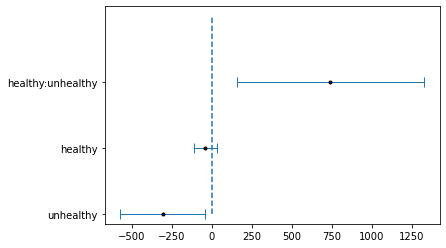

In [40]:
#We combine healthy and unhealthy features because there are not independent
c_logistic_regression(lin_df, ["healthy*unhealthy"])

With this logistic regression model, we have a pseudo R-squared value of 29% with is good. We note that coefficient of `unhealthy` and the combined `unhealthy:healthy` are statistically significant having a p_value below 0.05. We note than `unhealthy` coefficient is negative meaning buying more unhealthy product lowers probabilty for the area to be wealthy. We note that fractions features are dependent since they sum to one. That's why we combined healthy to unhealthy. This last one has positive coefficient and is statistically significant. Combining this to the fact that `unhealthy` is also significant means that areas where fractions of unhealthy product are going to healthy product have higher probability to be wealthy.

#### Nutrients distribution study

Let's now look at the nutrient instead of the food category.

#### a) Histogram visualization

We procede the same way, let us visualize the different nutrient distribution.

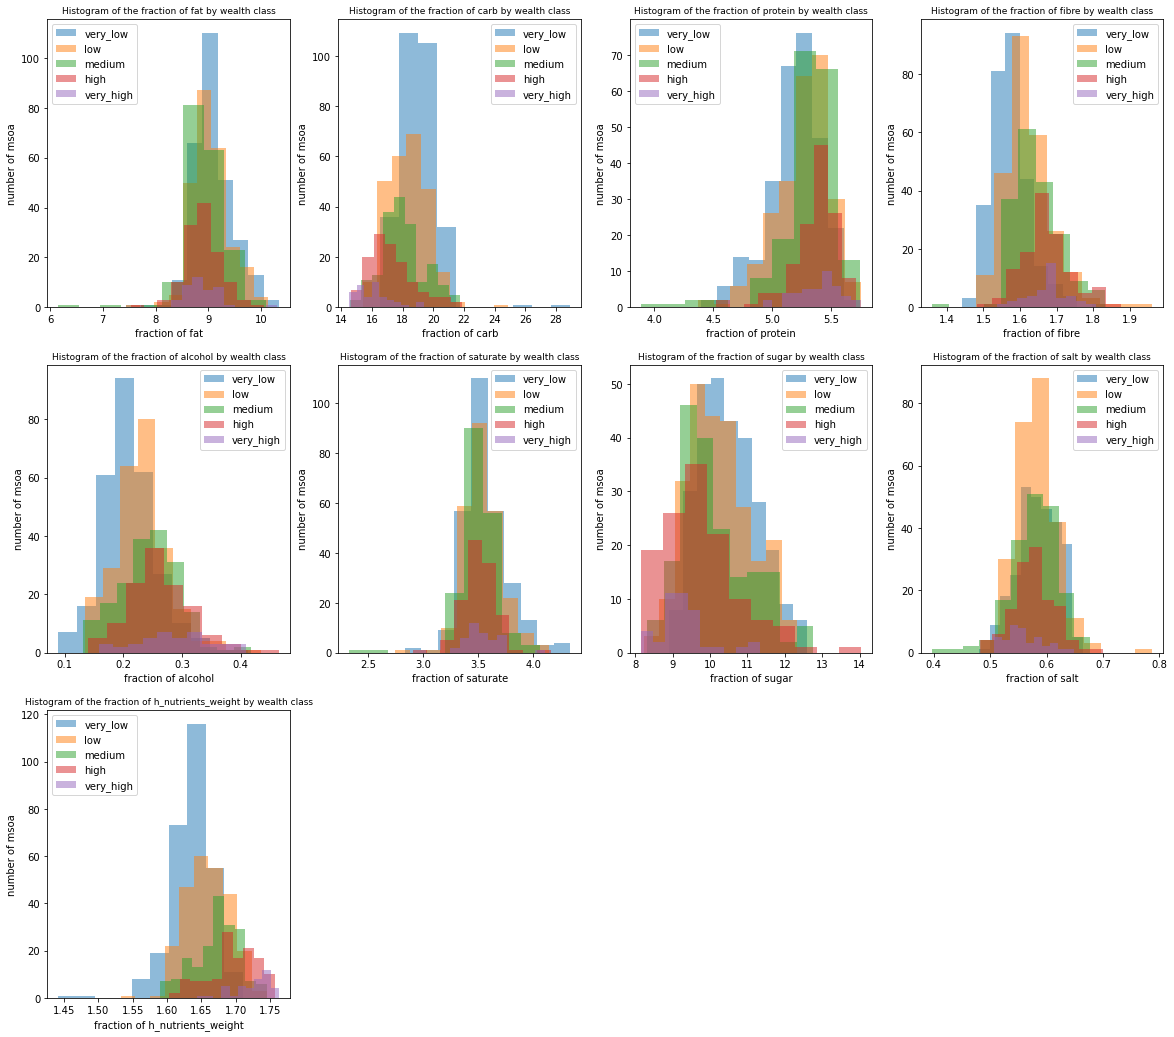

In [41]:
nutrients=['fat','carb','protein','fibre','alcohol','saturate','sugar','salt','h_nutrients_weight']
a_hist_plots(main_df, nutrients, wealth_class_labels)

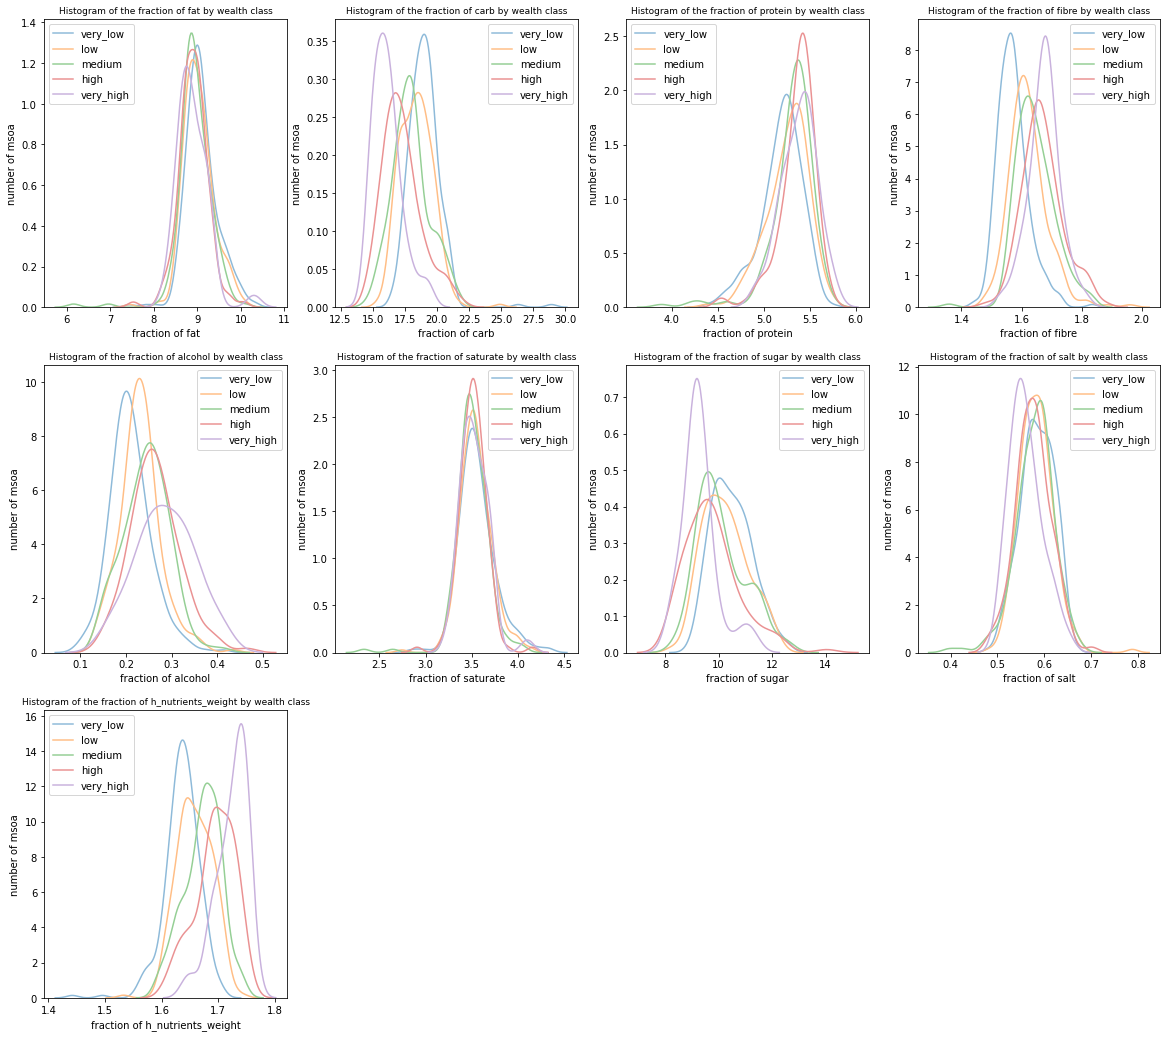

In [42]:
a_hist_plots(main_df, nutrients, wealth_class_labels, plot_type="kde")

It seems there are positive correlations with entropy, alcohol, fibre, and protein.  
On the other side, there seems to be a negative correlation with salt, carb and sugar.

#### b) spearman correlation

Let's validate our observations with spearman correlation.

In [43]:
display_spearmanRank_textual(b_spearman_rank(main_df, nutrients))

Following categories have a statisticaly significant correlation with the median income


First those that are positively correlated with median income

- h_nutrients_weight have coefficient +0.59 with p value of order 10^-82
-              fibre have coefficient +0.58 with p value of order 10^-80
-            alcohol have coefficient +0.43 with p value of order 10^-40
-            protein have coefficient +0.31 with p value of order 10^-21


Now those that are negatively correlated with median income

-               carb have coefficient -0.49 with p value of order 10^-53
-              sugar have coefficient -0.34 with p value of order 10^-25
-                fat have coefficient -0.21 with p value of order 10^-9
-               salt have coefficient -0.13 with p value of order 10^-4
-           saturate have coefficient -0.08 with p value of order 10^-1


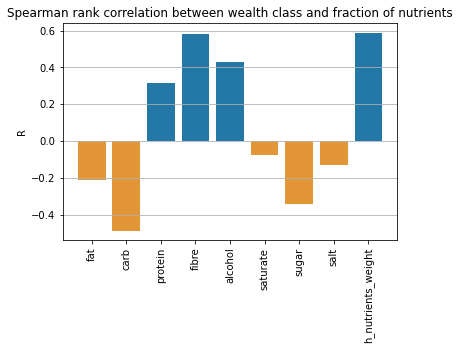

In [44]:
display_spearmanRank_histogram(b_spearman_rank(main_df, nutrients),
                  "Spearman rank correlation between wealth class and fraction of nutrients")

All correlations are statistically significant except for saturate. We indeed note strong positive correlation between both fibre, entropy, protein, alcohol and fat with median income wheras we note negative correlation with dat, carb, sugar and salt. If we consider protein, fibre and entropy as health markers, we indeed have a strong correlation health - wealth.

#### c) logistic regression

Finally, we use logistic regression to predict the probability an area is wealthy using mean weigh of nutrients in bough products. We discard alcohol as it is not a nutrient properly.

Optimization terminated successfully.
         Current function value: 0.264315
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           wealth_class   No. Observations:                  886
Model:                          Logit   Df Residuals:                      877
Method:                           MLE   Df Model:                            8
Date:                Sun, 13 Dec 2020   Pseudo R-squ.:                  0.4521
Time:                        20:59:15   Log-Likelihood:                -234.18
converged:                       True   LL-Null:                       -427.38
Covariance Type:            nonrobust   LLR p-value:                 1.520e-78
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -147.6988     30.990     -4.766      0.000    -208.437     -86.960
fat  

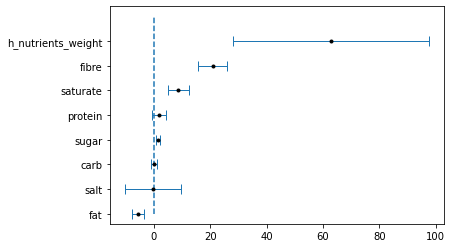

In [45]:
c_logistic_regression(main_df, ['fat','carb','saturate','sugar',
                              'protein','fibre','salt','h_nutrients_weight'])

This logistic regression has 45.3% pseudo R-squared value which is greater than for our previous experiment. It means these results cover a greater part of the variance making more relevant. We note all coefficients except salt, protein and carb are statistically significant. Both `h_nutrients_weight`, `fibre`, `sugar` and `saturate` have positive coefficients whereas `fat` has negative coefficients. We conclude the entropy has the highest influence on wealth class with fibre which are markers of health.

These results are in line with the Spearman conclusions which gives even more confidence that indeed, there is an impact of wealth class on eating habits. In this last regression experiment, eating habits explain 45.3% of wealth class variance.

# TODO: Conclusion and limitations

TODO